In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.formula.api as smf 
from scipy.interpolate import interp1d
import seaborn.objects as so
#Importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans

In [3]:
cancellations_hospital_fp = os.path.join(os.getcwd(), "datasets", "cancellations_by_hospital.csv")
cancellations_hospital = pd.read_csv(cancellations_hospital_fp)

hospital_names_fp = os.path.join(os.getcwd(), "datasets", "hospitals_scotland.csv")
hospital_names = pd.read_csv(hospital_names_fp)

In [4]:
cancellations_hospital.isna().sum()

_id                               0
Month                             0
Hospital                          0
TotalOperations                   0
TotalOperationsQF              4502
TotalCancelled                    0
TotalCancelledQF               4502
CancelledByPatientReason          0
CancelledByPatientReasonQF     4502
ClinicalReason                    0
ClinicalReasonQF               4502
NonClinicalCapacityReason         0
NonClinicalCapacityReasonQF    4502
OtherReason                       0
OtherReasonQF                  4502
dtype: int64

In [5]:
# drop unncessary columns
cancellations_hospital.drop(columns=["_id","TotalOperationsQF","TotalCancelledQF","CancelledByPatientReasonQF","ClinicalReasonQF","NonClinicalCapacityReasonQF","OtherReasonQF"], inplace=True)
cancellations_hospital

,Month,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
0,201505,A111H,884,67,21,25,16,5
1,201506,A111H,945,84,39,30,12,3
2,201507,A111H,948,72,25,33,6,8
3,201508,A111H,882,74,42,18,12,2
4,201509,A111H,845,67,32,30,3,2
...,...,...,...,...,...,...,...,...
4497,202401,Z102H,164,27,16,3,8,0
4498,202401,T101H,822,69,26,27,2,14
4499,202401,T202H,336,22,4,11,1,6
4500,202401,T312H,392,40,16,9,2,13


In [6]:
# change data type for month
cancellations_hospital["Month"] = pd.to_datetime(cancellations_hospital.Month, format="%Y%m")

In [7]:
cancellations_hospital.rename(columns={"Month":"Date"}, inplace=True)
cancellations_hospital

,Date,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
0,2015-05-01,A111H,884,67,21,25,16,5
1,2015-06-01,A111H,945,84,39,30,12,3
2,2015-07-01,A111H,948,72,25,33,6,8
3,2015-08-01,A111H,882,74,42,18,12,2
4,2015-09-01,A111H,845,67,32,30,3,2
...,...,...,...,...,...,...,...,...
4497,2024-01-01,Z102H,164,27,16,3,8,0
4498,2024-01-01,T101H,822,69,26,27,2,14
4499,2024-01-01,T202H,336,22,4,11,1,6
4500,2024-01-01,T312H,392,40,16,9,2,13


In [8]:
#pd.set_option('display.max_rows', None)
hospital_considered = cancellations_hospital['Hospital'].value_counts()[cancellations_hospital['Hospital'].value_counts() > 104].index.tolist()
# taking hospital with the most complete data, full complete months
cancellations_hospital_considered = cancellations_hospital[cancellations_hospital["Hospital"].isin(hospital_considered)]
cancellations_hospital_considered.Hospital.value_counts()
print(len(cancellations_hospital_considered.Hospital.value_counts()))
# there are 49 hospitals in the original data but only hospitals with complete data are considered so there are now only 30 hospitals
cancellations_hospital_clean = cancellations_hospital_considered.groupby(["Hospital"]).sum().reset_index()
cancellations_hospital_clean_hos = cancellations_hospital_considered.groupby(["Hospital"]).sum()
cancellations_hospital_clean

30


/var/folders/16/jctzkwyn5k5gvk9tx998xk8h0000gn/T/ipykernel_77037/840799752.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cancellations_hospital_clean = cancellations_hospital_considered.groupby(["Hospital"]).sum().reset_index()
/var/folders/16/jctzkwyn5k5gvk9tx998xk8h0000gn/T/ipykernel_77037/840799752.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cancellations_hospital_clean_hos = cancellations_hospital_considered.groupby(["Hospital"]).sum()


,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
0,A111H,65294,5998,2195,2331,1222,250
1,A210H,87705,9723,2614,4660,1850,599
2,B120H,34069,3477,888,807,1731,51
3,C121H,8203,1120,634,224,255,7
4,C418H,68460,5487,2234,2021,1011,221
5,D102H,176322,9871,3545,3032,3294,0
6,F704H,59957,5121,788,2000,2279,54
7,G107H,81033,5534,1646,2241,1509,138
8,G405H,91190,7387,1173,3214,2791,209
9,G513H,68633,6262,1758,2554,1783,167


In [9]:
cancellations_hospital_clean_hos

,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
Hospital,,,,,,
A111H,65294,5998,2195,2331,1222,250
A210H,87705,9723,2614,4660,1850,599
B120H,34069,3477,888,807,1731,51
C121H,8203,1120,634,224,255,7
C418H,68460,5487,2234,2021,1011,221
D102H,176322,9871,3545,3032,3294,0
F704H,59957,5121,788,2000,2279,54
G107H,81033,5534,1646,2241,1509,138
G405H,91190,7387,1173,3214,2791,209


In [10]:
cancellations_hospital_clean_hos.drop(columns=["TotalOperations","TotalCancelled"], inplace=True)

PC1 explains 74% of the variance.
PC2 explains 18% of the variance.
PC3 explains 5% of the variance.
PC4 explains 3% of the variance.
30


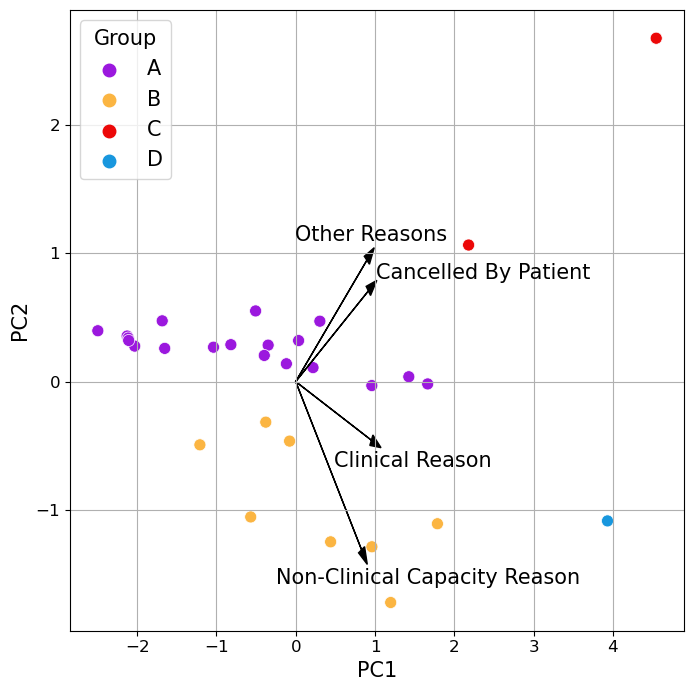

In [44]:
def standardize(df):
    standardized = pd.DataFrame()
    for col in df.columns: # We can apply mathematical operation to entire columns at once, as they are built on top of numpy arrays
        standardized[col] = (df[col]-df[col].mean())/df[col].std() #For each column move the data s.t. it is centered around 0 and has variance=1
    return standardized

def principal_component_analysis(df):
    standardized = standardize(df)
    cov_matrix = np.cov(standardized.values.T) # Transpose the dataset, as pandas stores data in rows x features and the covariance would be computed as the covariance of the rows, but we are interested in the covariance of the features
    return np.linalg.eig(cov_matrix)

def sort_eigenvalues(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

def principal_component_analysis(df):
    standardized = standardize(df) # Standardise the data
    cov_matrix = np.cov(standardized.values.T) # Compute the covariance matrix 
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) 
    eigenvalues, eigenvectors = sort_eigenvalues(eigenvalues, eigenvectors)
    for i in range(len(eigenvalues)):
        print('PC' + str(i+1) + ' explains ' + str(round((eigenvalues[i] / np.sum(eigenvalues))*100)) + '% of the variance.')
    return (eigenvalues, eigenvectors)

standardized = standardize(cancellations_hospital_clean_hos)

e_values, e_vectors = principal_component_analysis(cancellations_hospital_clean_hos) #e_vectors is already in the right format
result = standardized.dot(e_vectors[:,:2])
result_index = result.reset_index()

groupAmask = result_index[(-result_index[0] < 2) & (-result_index[1] > -0.05) & (-result_index[1] < 1)]
groupAmask_hos = groupAmask["Hospital"].tolist()

groupBmask = result_index[(-result_index[0] < 2) & (-result_index[1] < -0.05)]
groupBmask_hos = groupBmask["Hospital"].tolist()

groupCmask = result_index[(-result_index[0] > 2) & (-result_index[1] > 1)]
groupCmask_hos = groupCmask["Hospital"].tolist()

groupDmask = result_index[(-result_index[0] > 2) & (-result_index[1] < -0.05)]
groupDmask_hos = groupDmask["Hospital"].tolist()

group_list = []
for i in range(len(result_index)):
    
    if result_index["Hospital"][i] in groupAmask_hos:
        group_list.append("A")
    elif result_index["Hospital"][i] in groupBmask_hos:
        group_list.append("B")
    elif result_index["Hospital"][i] in groupCmask_hos:
        group_list.append("C")
    elif result_index["Hospital"][i] in groupDmask_hos:
        group_list.append("D")
    else:
        group_list.append("E")

print(len(group_list))
result_index["Group"] = group_list

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x= -result_index[0], y = -result_index[1], hue=result_index["Group"], palette={"A":"#9B18DE","B":"#FBB542","C":"#EC0808","D":"#1897DE"}, s=75, hue_order=["A","B","C","D"], legend="full", edgecolors="black", linewidth=0.5)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)

x = -result_index[0]
y = -result_index[1]

vec = e_vectors[:,:2]

reasons = list(cancellations_hospital_clean_hos)
reasons[0] = "Cancelled By Patient"
reasons[1] = "Clinical Reason"
reasons[2] = 'Non-Clinical Capacity Reason'
reasons[3] = 'Other Reasons'

plt.arrow(0, 0, -vec[0,0] * 2, -vec[0,1] * 2,color = 'black',alpha = 1,shape='full',length_includes_head=True, head_width=.09)
plt.text(-vec[0,0]* 0.5 * 2 + 0.5, -vec[0,1] * 1 * 2 + 0.01, reasons[0], fontsize=15)

plt.arrow(0, 0, -vec[1,0] * 2, -vec[1,1] * 2,color = 'black',alpha = 1,shape='full',length_includes_head=True, head_width=.09)
plt.text(-vec[1,0]* 0.5 * 2 - 0.05, -vec[1,1] * 1 * 2 - 0.15, reasons[1], fontsize=15)

plt.arrow(0, 0, -vec[2,0] * 2, -vec[2,1] * 2,color = 'black',alpha = 1,shape='full',length_includes_head=True, head_width=.09)
plt.text(-vec[2,0]* 0.5 * 2 -0.7, -vec[2,1] * 1 * 2 - 0.15, reasons[2], fontsize=15)

plt.arrow(0, 0, -vec[3,0] * 2, -vec[3,1] * 2,color = 'black',alpha = 1, shape='full',length_includes_head=True, head_width=.09)
plt.text(-vec[3,0]* 0.5 * 2 -0.5, -vec[3,1] * 1 * 2 + 0.05, reasons[3], fontsize=15)
    
    
plt.tight_layout()
plt.legend(title="Group",title_fontsize = 15, fontsize=15, markerscale=1.5)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.grid()
plt.plot()
plt.savefig('figure3.pdf')

In [48]:
groupA_cancellation = cancellations_hospital_clean_hos[cancellations_hospital_clean_hos.index.isin(groupAmask_hos)]

In [49]:
groupA_cancellation

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
Hospital,,,,
A111H,2195,2331,1222,250
A210H,2614,4660,1850,599
C121H,634,224,255,7
C418H,2234,2021,1011,221
G516H,2339,2700,967,292
H103H,588,498,276,4
L106H,3589,2744,966,208
L302H,3458,2233,1563,160
L308H,1744,1648,1309,310


In [50]:
groupB_cancellation = cancellations_hospital_clean_hos[cancellations_hospital_clean_hos.index.isin(groupBmask_hos)]

In [51]:
groupB_cancellation

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
Hospital,,,,
B120H,888,807,1731,51
D102H,3545,3032,3294,0
F704H,788,2000,2279,54
G107H,1646,2241,1509,138
G405H,1173,3214,2791,209
G513H,1758,2554,1783,167
H202H,3329,2726,4196,57
S314H,2060,3707,3719,574


In [52]:
groupC_cancellation = cancellations_hospital_clean_hos[cancellations_hospital_clean_hos.index.isin(groupCmask_hos)]

In [53]:
groupC_cancellation

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
Hospital,,,,
S116H,8017,3948,2161,1550
S308H,5487,3321,1862,710


In [54]:
groupD_cancellation = cancellations_hospital_clean_hos[cancellations_hospital_clean_hos.index.isin(groupDmask_hos)]

In [55]:
groupD_cancellation

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
Hospital,,,,
N101H,4479,5362,4789,827


In [57]:
hospital_names = hospital_names[["HospitalCode","HospitalName"]]

In [58]:
hospital_names

,HospitalCode,HospitalName
0,A101H,Arran War Memorial Hospital
1,A103H,Ayrshire Central Hospital
2,A105H,Kirklandside Hospital
3,A110H,Lady Margaret Hospital
4,A111H,University Hospital Crosshouse
...,...,...
271,T324H,Dudhope Young Peoples Inpatient Unit
272,T325H,CAMHS Hospital Unit
273,W106H,St Brendans Cot Hospital
274,W107H,Western Isles Hospital


In [59]:
groupA_names = groupA_cancellation.merge(hospital_names, left_index=True, right_on="HospitalCode")

In [60]:
groupA_names

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,HospitalCode,HospitalName
4,2195,2331,1222,250,A111H,University Hospital Crosshouse
10,2614,4660,1850,599,A210H,University Hospital Ayr
158,634,224,255,7,C121H,Lorn & Islands Hospital
113,2234,2021,1011,221,C418H,Royal Alexandra Hospital
136,2339,2700,967,292,G516H,West Glasgow
161,588,498,276,4,H103H,Caithness General Hospital
188,3589,2744,966,208,L106H,University Hospital Monklands
198,3458,2233,1563,160,L302H,University Hospital Hairmyres
203,1744,1648,1309,310,L308H,University Hospital Wishaw
75,766,726,547,95,N102H,Woodend General Hospital


In [61]:
groupB_names = groupB_cancellation.merge(hospital_names, left_index=True, right_on="HospitalCode")

In [63]:
groupB_names

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,HospitalCode,HospitalName
23,888,807,1731,51,B120H,Borders General Hospital
239,3545,3032,3294,0,D102H,Golden Jubilee University National Hospital
54,788,2000,2279,54,F704H,Victoria Hospital
117,1646,2241,1509,138,G107H,Glasgow Royal Infirmary
129,1173,3214,2791,209,G405H,Queen Elizabeth University Hospital
135,1758,2554,1783,167,G513H,Royal Hospital for Children
165,3329,2726,4196,57,H202H,Raigmore Hospital
230,2060,3707,3719,574,S314H,Royal Infirmary of Edinburgh at Little France


In [64]:
groupC_names = groupC_cancellation.merge(hospital_names, left_index=True, right_on="HospitalCode")

In [66]:
groupC_names

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,HospitalCode,HospitalName
209,8017,3948,2161,1550,S116H,Western General Hospital
224,5487,3321,1862,710,S308H,St John's Hospital


In [67]:
groupD_names = groupD_cancellation.merge(hospital_names, left_index=True, right_on="HospitalCode")

In [68]:
groupD_names

,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,HospitalCode,HospitalName
74,4479,5362,4789,827,N101H,Aberdeen Royal Infirmary


In [74]:
cancellations_hospital_clean.sort_values(by="TotalCancelled", ascending=False)

,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason
21,S116H,122752,15676,8017,3948,2161,1550
16,N101H,146182,15457,4479,5362,4789,827
22,S308H,109269,11380,5487,3321,1862,710
12,H202H,82030,10308,3329,2726,4196,57
23,S314H,120638,10060,2060,3707,3719,574
5,D102H,176322,9871,3545,3032,3294,0
1,A210H,87705,9723,2614,4660,1850,599
25,T101H,110980,8843,2589,3023,2531,700
27,V217H,88208,8437,2940,2931,2125,441
13,L106H,69068,7507,3589,2744,966,208
